In [1]:
import os

import h5py
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import sklearn

In [2]:
import phate

In [3]:
os.chdir('..')
import manifold_methods
import plotting
import mappings
import data_loader

In [4]:
exp_path = '/lustre06/project/6065672/shared/DietNet/1KGB_POP24/1KGP/WGS30X_V1/oldnow/MattsPlace'
fname = '1000G.2504_WGS30x.GSA17k_MHI.intersectGSA.miss10perc.maf0.05.pruned.autosomes.noHLA.phased_imputed_V1.hdf5'

In [5]:
inputs, class_labels, samples, snp_names, class_label_names = data_loader.load_data_1000G(os.path.join(exp_path, fname))
label_with_names, label_with_superpop_names = data_loader.preprocess_labels_1000G(class_labels, class_label_names)

In [6]:
pca_obj = sklearn.decomposition.PCA(n_components=100, random_state=42)
pca_input = pca_obj.fit_transform(inputs)

## Admix Ratios

In [7]:
def load_admix_ratio(sample_ids_path, admix_ratios_path, samples, labels):
    admix_labels = np.zeros([len(samples), 3])

    sample_ids = pd.read_csv(sample_ids_path, sep=' ', header=None)
    admix_ratios = pd.read_csv(admix_ratios_path, sep=' ', header=None)

    admix_df = pd.concat([admix_ratios, sample_ids], axis=1)
    admix_df.columns = ['admix 1', 'admix 2', 'admix 3' , 'sample id']

    matching_indices = np.array([np.where(admix_df['sample id'][j] == samples)[0][0] if len(np.where(admix_df['sample id'][j] == samples)[0]) > 0 else -1 for j in range(len(admix_df))])
    for i, idx in enumerate(matching_indices):
        if idx != -1:
            admix_labels[idx] = admix_df.iloc[i].values[:3]

    # color in all EUR or AFR individuals as 1
    admix_labels_inc_EURAFR = admix_labels
    admix_labels_inc_EURAFR[labels == 'EUR', 2] = 1
    admix_labels_inc_EURAFR[labels == 'AFR', 0] = 1

    return admix_labels, admix_labels_inc_EURAFR

In [8]:
data_path = '/lustre07/scratch/sciclun4/data/1000G/phate_genetics/MyAdmix'
sample_ids_path = os.path.join(data_path, 'output_ids.txt')
admix_ratios_path = os.path.join(data_path, 'AMR_ACB_ASW.3.Q')

admix_labels, admix_labels_inc_EURAFR = load_admix_ratio(sample_ids_path, 
                                                         admix_ratios_path,
                                                         samples,
                                                         class_labels)

In [12]:
def plot_pc_vs_others(df, base_pc, other_pcs, score_names):
    """
    Plots base PC vs other PCs with continuous scores using a seismic color map.
    Points without a score are colored gray.

    Args:
    df (DataFrame): DataFrame containing PCA embeddings and scores.
    base_pc (str): Column name for the base principal component.
    other_pcs (list of str): List of column names for other principal components.
    """
    n = len(other_pcs)
    fig, ax = plt.subplots(n, len(score_names), figsize=(10 * len(score_names), 6 * n))

    for row, pc in enumerate(other_pcs):
        for col, score_name in enumerate(score_names):
            points = ax[row, col].scatter(
                df[~df[score_name].isna()][base_pc], df[~df[score_name].isna()][pc], 
                c=df[~df[score_name].isna()][score_name], cmap='seismic', edgecolor='k', 
                vmin=0, vmax=1, s=100, alpha=0.7
            )

            ax[row, col].scatter(
                df[df[score_name].isna()][base_pc], 
                df[df[score_name].isna()][pc], 
                color='gray', edgecolor='k', s=100, alpha=0.7, label=''
            )
            ax[row, col].set_xticks([])
            ax[row, col].set_yticks([])

            #ax[row, col].set_xlabel(base_pc)
            #ax[row, col].set_ylabel(pc)
            #ax[row, col].set_title(f'{base_pc} vs {pc}')
        ax[row, 0].set_ylabel(pc) # only first column
    
    for i, score_name in enumerate(score_names):
        ax[0, i].set_title(score_name, fontsize=25)

    #fig.colorbar(points, ax=axes, orientation='vertical', label=score_name)
    plt.tight_layout()
    plt.show()
    fig.savefig('pca_colored_by_admixture')

In [10]:
pca_df = pd.DataFrame()
pca_df[['PC{}'.format(k) for k in range(1,101)]] = pca_input
admix_labels[np.isclose(admix_labels, 0)] = np.nan
pca_df[["African ancestry (%)", "Amerindigenous ancestry (%)", "European ancestry (%)"]] = admix_labels

/tmp/ipykernel_3706744/4229874294.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  pca_df[["African ancestry (%)", "Amerindigenous ancestry (%)", "European ancestry (%)"]] = admix_labels
/tmp/ipykernel_3706744/4229874294.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  pca_df[["African ancestry (%)", "Amerindigenous ancestry (%)", "European ancestry (%)"]] = admix_labels
/tmp/ipykernel_3706744/4229874294.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many tim

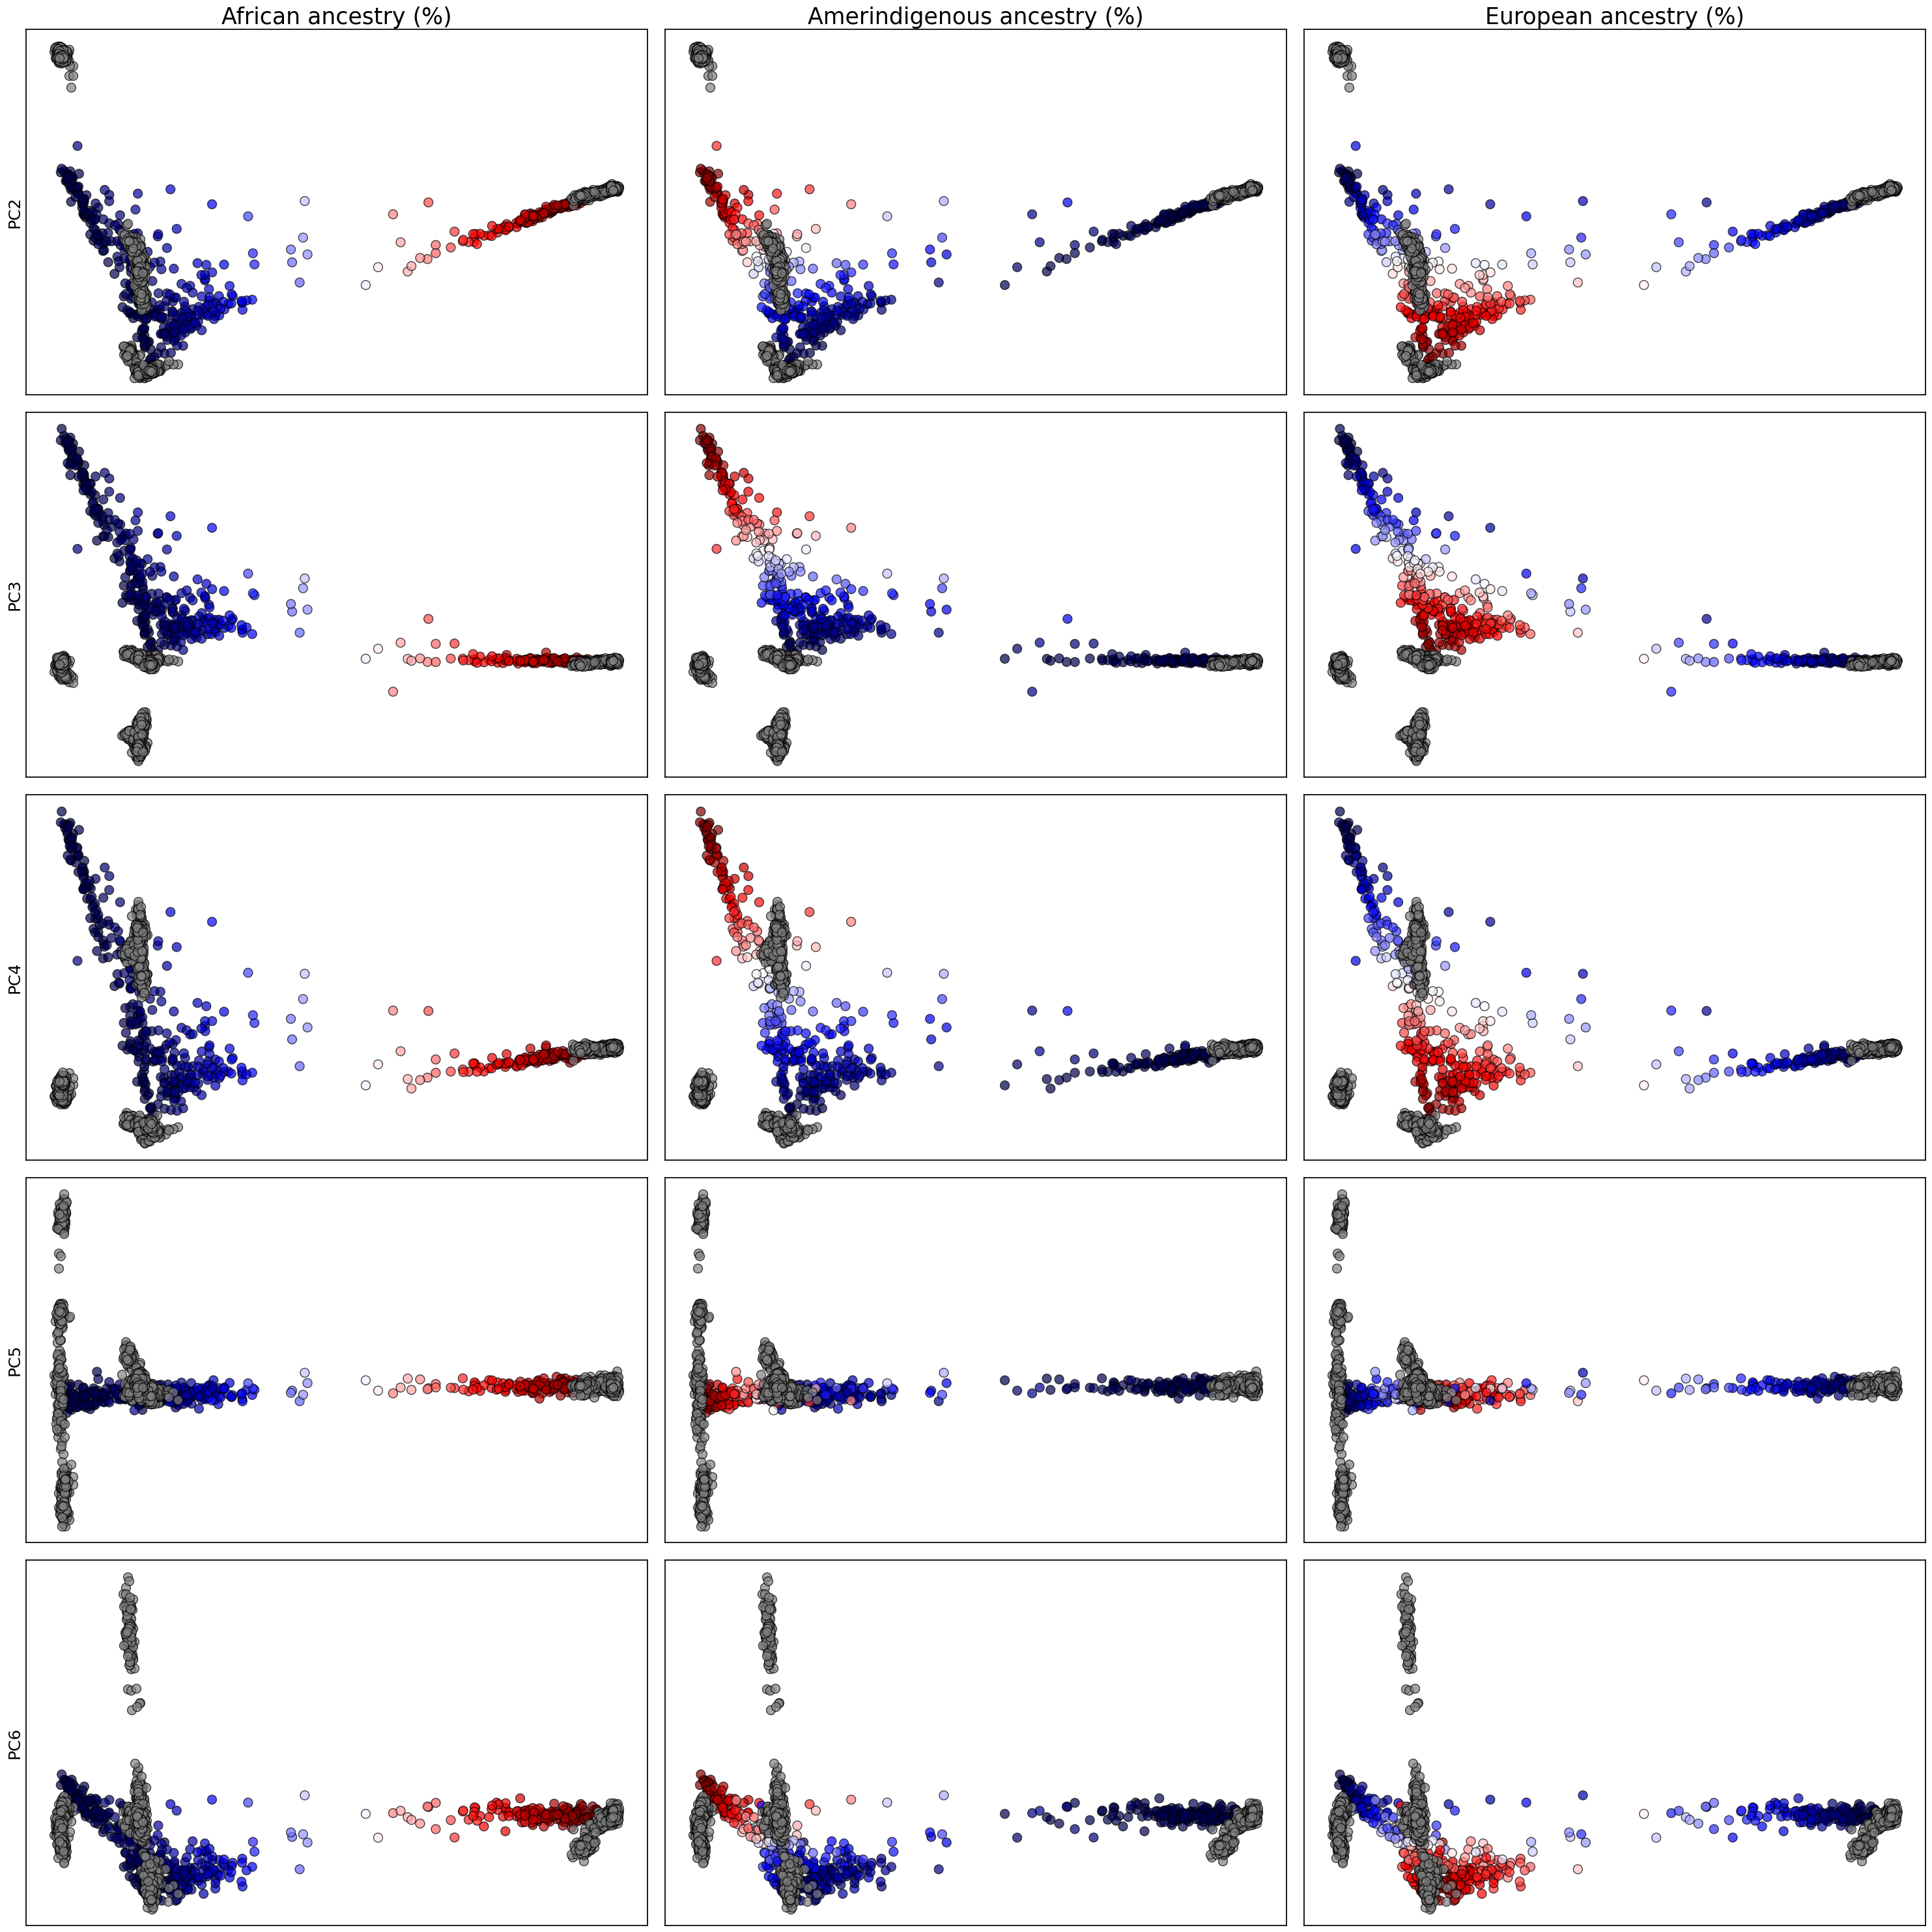

In [13]:
base_pc = 'PC1'
other_pcs = ['PC2', 'PC3', 'PC4', 'PC5', 'PC6']
plot_pc_vs_others(pca_df, base_pc, other_pcs, 
                  ["African ancestry (%)", "Amerindigenous ancestry (%)", "European ancestry (%)"])

## Admix Plot

In [ ]:
order = np.argsort(np.array(label_with_names)[matching_indices])
pop_label_names_admix = np.array(label_with_names)[matching_indices][order]
admix_ratios_ordered = admix_ratios.loc[order]

cutoffs = []
labels_ordered = np.unique(pop_label_names_admix)

for label in labels_ordered:
    cutoffs.append(np.where(label == pop_label_names_admix)[0].min())
cutoffs += [len(pop_label_names_admix)]

In [ ]:
# Assuming each column in your CSV represents an ancestry component
fig, ax = plt.subplots(figsize=(10, 5))  # Adjust the size as needed

# Plot each population/ancestry component in a stacked manner
admix_ratios_ordered.plot(kind='bar', stacked=True, ax=ax, width=1.0, edgecolor='none')

# Optional: Customize the axes and layout
ax.set_xlabel('Individuals')
ax.set_ylabel('Ancestry Proportion')
ax.set_title('Admixture Plot')
#ax.get_xaxis().set_visible(False)
plt.xticks(rotation=0)  # Rotate the x-axis labels to horizontal
ax.legend(title='Populations')

ax.legend(bbox_to_anchor=(1.1, 1.05), 
          loc='upper left',
          labels=["African ancestry (%)",
                  "Amerindigenous ancestry (%)",
                  "European ancestry (%)"])

for i, pos in enumerate(cutoffs[1:]):
    ax.axvline(x=pos, linestyle='--', color='black')

plt.xticks(ticks=[(cutoffs[i]+cutoffs[i+1])/2 for i in range(len(cutoffs)-1)], labels=labels_ordered)

# Show the plot
plt.show()